In this notebook we give a proof of concept of unitary compiling using TFQ. 

In [318]:
%load_ext autoreload
%autoreload 2

import sympy 
import numpy as np 
import pandas as pd 
import tensorflow as tf
from utilities.circuit_database import CirqTranslater
from utilities.templates import *
from utilities.variational import Minimizer
from utilities.misc import get_qubits_involved, reindex_symbol, shift_symbols_down
import matplotlib.pyplot as plt 
import tensorflow_quantum as tfq
import cirq
from utilities.compiling import *
from utilities.simplifier import Simplifier
from utilities.discrimination import *
from utilities.idinserter import IdInserter
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [401]:
translator = CirqTranslater(3, untouchable_blocks = [1])
translator.env_qubits = [2]

translator.encoder_id = 0
translator.channel_id = 1
translator.decoder_id = 2

### state prep

u2_layer_encoder = u2_db(translator, 0,1, block_id=translator.encoder_id)
channel_db = amplitude_damping_db(translator, qubits_ind=[1,2], eta=1, block_id = translator.channel_id)
u2_layer_decoder = u2_db(translator, 0,1, block_id=translator.decoder_id)

circuit_db = concatenate_dbs([u2_layer_encoder, channel_db, u2_layer_decoder])

circuit, circuit_db = translator.give_circuit(circuit_db)

#circuit

minimizer = Minimizer(translator, mode="discrimination")
etas = [0.01, 1.]


batch_circuits, trainable_symbols, trainable_params_value = prepare_optimization_discrimination(translator, circuit_db, etas)
cost, resolver, training_history = minimizer.minimize(batch_circuits, symbols = trainable_symbols, parameter_values = trainable_params_value )
circuit_db = translator.update_circuit_db_param_values(circuit_db, resolver)

In [402]:
from utilities.gate_killer import GateKiller

In [403]:
killer = GateKiller(translator, mode="discrimination", params=etas)

In [404]:
killed_db, new_cost = killer.remove_irrelevant_gates(cost, circuit_db)

kill 1qbit gate, try 0/30. Increased by: 4.490345872909529e-06%
kill 1qbit gate, try 1/30. Increased by: 4.898558927379781e-06%
kill 1qbit gate, try 2/30. Increased by: 4.082132363691926e-06%
kill 1qbit gate, try 3/30. Increased by: 4.898558927379781e-06%
kill 1qbit gate, try 4/30. Increased by: 0.0%


In [369]:
circuit_db

,ind,symbol,param_value,trainable,block_id,channel_param
0,6,th_0,-8.781865,True,0,NaN
1,9,th_1,-4.803280,True,0,NaN
2,6,th_2,7.375412,True,0,NaN
3,7,th_3,-2.984214,True,0,NaN
4,10,th_4,5.338327,True,0,NaN
5,7,th_5,-0.319163,True,0,NaN
6,0,None,10.222142,True,0,NaN
7,6,th_6,9.454099,True,0,NaN
8,13,th_7,14.657496,True,0,NaN
9,2,None,16.244552,True,0,NaN


In [371]:
blocks = list(set(circuit_db["block_id"]))
for b in translator.untouchable_blocks:
    blocks.remove(b)

candidates = []
for b in blocks:
    block_db = circuit_db[circuit_db["block_id"] == b]
    block_db_trainable = block_db[block_db["trainable"] == True]
    block_db_trainable = block_db_trainable[~block_db_trainable["symbol"].isna()]
    block_db_trainable = block_db_trainable[~block_db_trainable["symbol"].isna()]
    candidates += list(block_db_trainable.index)

killed_costs = []

In [378]:
for index_candidate in tqdm(candidates):
    killed_circuit_db = circuit_db.copy()
    killed_circuit_db = killed_circuit_db.drop(labels=[index_candidate])
    killed_circuit_db = shift_symbols_down(translator, index_candidate+1, killed_circuit_db)

    if killer.model_class.__name__ == 'QNN_DISCRIMINATION':
        killed_batch_circuits, survival_symbols, survival_params_value = prepare_optimization_discrimination(translator, 
                                                                                                             killed_circuit_db, killer.discrimination_params )
        unitary_killer_model = killer.model_class(survival_symbols, killer.observable)
        #try:
        unitary_killer_model(killed_batch_circuits)
        unitary_killer_model.trainable_variables[0].assign(tf.convert_to_tensor(survival_params_value.astype(np.float32)))
        killed_costs.append(killer.give_cost_external_model(killed_batch_circuits, model=unitary_killer_model).numpy())
        # except Exception: ###it happened in the past that the circuit was too short. TO do, solve this in a more elegant way.
        #     killed_costs.append(np.inf)
        #     print("problem in unitary killer, index_candidate {}".format(index_candidate))
    else:
        raise NotImplementedError("...")



100%|██████████| 30/30 [00:17<00:00,  1.75it/s]


In [382]:
kk = killed_circuit_db.copy()

In [398]:
max_relative_increment = killer.max_relative_increment
initial_cost = cost
relative_increments = (np.array(killed_costs)-initial_cost)/np.abs(initial_cost)
if np.min(relative_increments) < max_relative_increment:
    index_to_kill = np.argmin(relative_increments)
    new_cost = killed_costs[index_to_kill]
    killed_circuit_db = circuit_db.copy()
    killed_circuit_db = killed_circuit_db.drop(labels=[index_to_kill])
    killed_circuit_db = shift_symbols_down(translator, index_to_kill+1, killed_circuit_db)

0

In [399]:
killed_circuit_db = shift_symbols_down(translator, index_candidate+1, killed_circuit_db)

,ind,symbol,param_value,trainable,block_id,channel_param
1,9,th_0,-4.803280,True,0,NaN
2,6,th_1,7.375412,True,0,NaN
3,7,th_2,-2.984214,True,0,NaN
4,10,th_3,5.338327,True,0,NaN
5,7,th_4,-0.319163,True,0,NaN
6,0,None,10.222142,True,0,NaN
7,6,th_5,9.454099,True,0,NaN
8,13,th_6,14.657496,True,0,NaN
9,2,None,16.244552,True,0,NaN
10,13,th_7,4.683316,True,0,NaN


In [392]:
killed_circuit_db = circuit_db.copy()

,ind,symbol,param_value,trainable,block_id,channel_param
0,6,th_0,-8.781865,True,0,NaN
1,9,th_1,-4.803280,True,0,NaN
2,6,th_2,7.375412,True,0,NaN
3,7,th_3,-2.984214,True,0,NaN
4,10,th_4,5.338327,True,0,NaN
5,7,th_5,-0.319163,True,0,NaN
6,0,None,10.222142,True,0,NaN
7,6,th_6,9.454099,True,0,NaN
8,13,th_7,14.657496,True,0,NaN
9,2,None,16.244552,True,0,NaN


In [380]:
np.kron(*[np.eye(2)]*2)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [343]:
NotImplementedError("aca")

NotImplementedError('aca')

30

In [284]:
#circuit, modi_db = translator.give_circuit(concatenate_dbs([circuit_db, z_layer_db(translator, block_id=3)]))

In [ ]:
max_relative_increment = 0.05

In [320]:
blocks = list(set(circuit_db["block_id"]))
for b in translator.untouchable_blocks:
    blocks.remove(b)

candidates = []
for b in blocks:

    block_db = circuit_db[circuit_db["block_id"] == b]
    block_db_trainable = block_db[block_db["trainable"] == True]
    block_db_trainable = block_db_trainable[~block_db_trainable["symbol"].isna()]
    block_db_trainable = block_db_trainable[~block_db_trainable["symbol"].isna()]
    
    
    candidates += list(block_db_trainable.index)

In [322]:
killed_costs = []

for index_candidate in tqdm(candidates):
    killed_circuit_db = circuit_db.copy()
    killed_circuit_db = killed_circuit_db.drop(labels=[index_candidate])
    killed_circuit_db = shift_symbols_down(translator, index_candidate+1, killed_circuit_db)
    
    killed_batch_circuits, survival_symbols, survival_params_value = prepare_optimization_discrimination(translator, killed_circuit_db, etas)
    
    unitary_killer_model = minimizer.model_class(survival_symbols, minimizer.observable)
    unitary_killer_model(killed_batch_circuits)
    unitary_killer_model.trainable_variables[0].assign(tf.convert_to_tensor(survival_params_value.astype(np.float32)))
    
    killed_costs.append(minimizer.give_cost_external_model(killed_batch_circuits, model=unitary_killer_model).numpy())

100%|██████████| 30/30 [00:17<00:00,  1.73it/s]


In [330]:
relative_increments = (np.array(killed_costs)-cost)/cost

In [ ]:
if np.min(relative_increments) < max_relative_increment:
    index_to_kill = np.argmin(relative_increments)
    killed_circuit_db = circuit_db.copy()
    killed_circuit_db = killed_circuit_db.drop(labels=[index_to_kill])
    killed_circuit_db = shift_symbols_down(translator, index_candidate+1, killed_circuit_db)

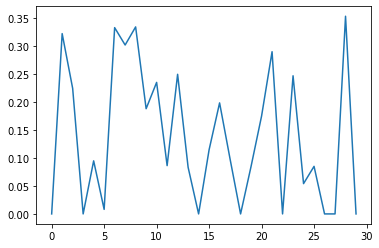

In [236]:
killed_circuit_db = circuit_db.copy()
#killed_circuit_db = killed_circuit_db.drop(labels=[index_candidate])
#killed_circuit_db = shift_symbols_down(translator, index_candidate+1, killed_circuit_db)

killed_batch_circuits, survival_symbols, survival_params_value = prepare_optimization_discrimination(translator, killed_circuit_db, etas)
unitary_killer_model = minimizer.model_class(survival_symbols, minimizer.observable)
unitary_killer_model(killed_batch_circuits)
unitary_killer_model.trainable_variables[0].assign(tf.convert_to_tensor(survival_params_value.astype(np.float32)))
minimizer.loss(*[unitary_killer_model(killed_batch_circuits)]*2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.48534584>

In [232]:
unitary_killer_model.trainable_variables[0]

<tf.Variable 'qnn_discrimination_399/expectation_399/circuit_learnable_parameters:0' shape=(30,) dtype=float32, numpy=
array([ 8.36090386e-01, -1.06676159e+01,  2.89929062e-01, -3.62957287e+00,
        1.14555063e+01, -7.28127897e-01,  1.49224913e+00,  4.81028414e+00,
       -1.14851599e+01,  7.26566935e+00,  1.93201399e+00,  1.01527748e+01,
       -3.94298625e+00, -1.03085196e+00,  1.69945729e+00, -7.94850349e+00,
       -3.17290950e+00, -7.42523193e+00,  1.12714252e+01, -9.14079857e+00,
        5.36332703e+00,  1.25663652e+01, -5.60503912e+00,  3.23685884e-01,
        1.11008537e+00, -9.66129494e+00,  3.25405313e-06,  1.21191635e+01,
       -3.06671143e+00,  1.18062057e+01], dtype=float32)>

In [233]:
minimizer.model.trainable_variables[0]

<tf.Variable 'qnn_discrimination_368/expectation_368/circuit_learnable_parameters:0' shape=(30,) dtype=float32, numpy=
array([ 8.36090386e-01, -1.06676159e+01,  2.89929062e-01, -3.62957287e+00,
        1.14555063e+01, -7.28127897e-01,  1.49224913e+00,  4.81028414e+00,
       -1.14851599e+01,  7.26566935e+00,  1.93201399e+00,  1.01527748e+01,
       -3.94298625e+00, -1.03085196e+00,  1.69945729e+00, -7.63282108e+00,
        2.57905394e-01, -7.94850349e+00, -3.17290950e+00, -7.42523193e+00,
        1.12714252e+01, -9.14079857e+00,  5.36332703e+00,  1.25663652e+01,
       -5.60503912e+00,  3.23685884e-01,  1.11008537e+00, -9.66129494e+00,
        3.25405313e-06,  1.21191635e+01], dtype=float32)>

In [243]:
batch_circuits, trainable_symbols, trainable_params_value = prepare_optimization_discrimination(translator, killed_circuit_db, etas)

In [244]:
minimizer.loss(*[minimizer.model(batch_circuits)]*2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.14601332>

In [245]:
killed_circuit_db = circuit_db.copy()
killed_batch_circuits, survival_symbols, survival_params_value = prepare_optimization_discrimination(translator, killed_circuit_db, etas)
umode = minimizer.model_class(survival_symbols, minimizer.observable)
umode(killed_batch_circuits)
umode.trainable_variables[0].assign(tf.convert_to_tensor(survival_params_value.astype(np.float32)))
minimizer.loss(*[umode(batch_circuits)]*2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.48534584>

In [277]:
pa1 = survival_params_value.values

In [278]:
pa2 = translator.get_trainable_params_value(circuit_db).values

In [279]:
pa1 == pa2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [281]:
pa2 == minimizer.model.trainable_variables[0].numpy()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [272]:
survival_params_value.values

array([ -8.52346992,  12.56640911,  11.19355392,  -2.13488984,
        11.62775612, -16.24269104,  -5.84163523,   6.51778507,
        15.70796013,  -5.70069122,  11.80292511,  13.13291454,
         4.0658617 ,  18.84955406,  -9.80992985, -12.6176939 ,
         1.39786851,  19.56537437,   4.60682917,   6.40339613,
         4.71239185,   4.71239328,  -1.57080185,   1.57079387,
        -8.76318169,   7.95953417, -27.55848694,  11.78474617,
        -6.39982654,  -0.04943787])

In [273]:
minimizer.model.trainable_variables[0].numpy()

array([ -8.52347  ,  12.566409 ,  11.193554 ,  -2.1348898,  11.627756 ,
       -16.242691 ,  -5.841635 ,   6.517785 ,  15.70796  ,  -5.700691 ,
        11.802925 ,  13.132915 ,   4.0658617,  18.849554 ,  -9.80993  ,
         4.0493765,  -2.9015286, -12.617694 ,   1.3978685,  19.565374 ,
         4.606829 ,   6.403396 ,   4.712392 ,   4.7123933,  -1.5708019,
         1.5707939,  -8.763182 ,   7.959534 , -27.558487 ,  11.784746 ],
      dtype=float32)

In [276]:
minimizer.model.trainable_variables[0].numpy() == translator.get_trainable_params_value(circuit_db).values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
minimizer.model

In [189]:
index_candidate = candidates[-1]

In [192]:
killed_circuit_db = circuit_db.copy()
killed_circuit_db = killed_circuit_db.drop(labels=[index_candidate])
killed_circuit_db = shift_symbols_down(translator, index_candidate+1, killed_circuit_db)

<tf.Variable 'UnreadVariable' shape=(35,) dtype=float32, numpy=
array([ -7.5639486 , -12.323514  ,   2.9956543 ,  -1.225029  ,
         8.83897   ,  -2.6570396 ,  -1.217109  ,  -0.3291594 ,
        -5.773893  ,  -0.02537766,   3.0512245 ,   1.1152626 ,
         8.866069  , -11.183607  ,   5.2946687 ,  -6.36054   ,
         4.4531636 ,   1.408257  ,   3.1050994 ,  -0.19842157,
        -1.0505066 ,  -4.690259  ,   3.9435654 ,   3.6655378 ,
         6.1507707 ,   5.8971634 ,   4.68604   ,  -2.7838554 ,
         5.2277045 ,  -4.000388  ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ], dtype=float32)>

In [180]:
candidates[np.argmin(killed_costs)]

34

In [185]:
unitary_killer_model.trainable_variables

[<tf.Variable 'qnn_discrimination_313/expectation_313/circuit_learnable_parameters:0' shape=(35,) dtype=float32, numpy=
 array([4.424291  , 5.3947606 , 0.10849769, 3.1368148 , 2.508582  ,
        3.534945  , 2.3475435 , 4.621016  , 4.433874  , 1.3207507 ,
        4.974452  , 6.041713  , 0.6684681 , 5.2830706 , 6.129201  ,
        3.4747632 , 4.4645143 , 0.04447346, 4.8290772 , 5.949737  ,
        4.7985797 , 3.6839223 , 2.929514  , 4.004794  , 5.5625668 ,
        1.3053555 , 1.0178577 , 4.1340265 , 2.5310347 , 0.09509258,
        5.5062547 , 5.2100086 , 3.4384637 , 1.3360531 , 5.9721985 ],
       dtype=float32)>]

In [186]:
unitary_killer_model.symbols

ListWrapper(['th_0', 'th_1', 'th_2', 'th_3', 'th_4', 'th_5', 'th_6', 'th_7', 'th_8', 'th_9', 'th_10', 'th_11', 'th_12', 'th_13', 'th_14', 'th_17', 'th_18', 'th_19', 'th_20', 'th_21', 'th_22', 'th_23', 'th_24', 'th_25', 'th_26', 'th_27', 'th_28', 'th_29', 'th_30', 'th_31', 'th_32', 'th_33', 'th_34', 'th_35', 'th_36'])

['th_0',
 'th_1',
 'th_2',
 'th_3',
 'th_4',
 'th_5',
 'th_6',
 'th_7',
 'th_8',
 'th_9',
 'th_10',
 'th_11',
 'th_12',
 'th_13',
 'th_14',
 'th_17',
 'th_18',
 'th_19',
 'th_20',
 'th_21',
 'th_22',
 'th_23',
 'th_24',
 'th_25',
 'th_26',
 'th_27',
 'th_28',
 'th_29',
 'th_30',
 'th_31',
 'th_32',
 'th_33',
 'th_34',
 'th_35',
 'th_36']

In [169]:
killed_costs

[0.49602294,
 0.48492002,
 0.49629903,
 0.4787805,
 0.42816806,
 0.4300202,
 0.4858299,
 0.49633598,
 0.42846417,
 0.4621197,
 0.48185438,
 0.49001896,
 0.41385275,
 0.49745893,
 0.46259862,
 0.37102747,
 0.44911987,
 0.42798483,
 0.41466385,
 0.47493106,
 0.48041236,
 0.42378008,
 0.46490633,
 0.4588933,
 0.47561616,
 0.4120258,
 0.48969746,
 0.49343884,
 0.4527728,
 0.47416246,
 0.38131726,
 0.494689,
 0.4334966]

In [105]:
killed_circuit_db = copy.deepcopy(circuit_db)
killed_circuit_db = killed_circuit_db.drop(labels=[34])
killed_circuit_db = shift_symbols_down(translator, index_candidate+1, killed_circuit_db)


In [106]:
killed_batch_circuits, survival_symbols, survival_params_value = prepare_optimization_discrimination(translator, killed_circuit_db, etas)
unitary_killer_model = minimizer.model_class(survival_symbols, minimizer.observable)

In [107]:
minimizer.give_cost_external_model(batch_circuits, model=unitary_killer_model).numpy()

InvalidArgumentError: Could not find symbol in parameter map: th_23 [Op:TfqSimulateExpectation]

In [ ]:

killed_batch_circuits, survival_symbols, survival_params_value = prepare_optimization_discrimination(translator, killed_circuit_db, etas)

unitary_killer_model = minimizer.model_class(survival_symbols, minimizer.observable)
killed_costs.append(minimizer.give_cost_external_model(batch_circuits, model=unitary_killer_model).numpy())

In [88]:
batch_circuits, survival_symbols, survival_params_value = prepare_optimization_discrimination(translator, circuit_db, etas)

In [89]:
minimizer.give_cost(batch_circuits)

<tf.Tensor: shape=(), dtype=float32, numpy=0.14601344>

In [93]:
np.min(killed_costs)

0.3521489

In [99]:
translator.give_circuit(circuit_db, unresolved=True)[0]

(0, 0): ───Rz(th_0)───Rx(th_1)───Rz(th_2)───@───Rz(th_6)───X──────────────@───Rz(th_9)────Rx(th_10)───Rz(th_11)───Rz(th_17)───Rx(th_18)───Rz(th_19)──────────────────────────────────────────────────────────────────@───Rz(th_23)───X───────────────@───Rz(th_26)───Rx(th_27)───Rz(th_28)───
                                            │              │              │                                                                                                                                          │               │               │
(0, 1): ───Rz(th_3)───Rx(th_4)───Rz(th_5)───X───Ry(th_7)───@───Ry(th_8)───X───Rz(th_12)───Rx(th_13)───Rz(th_14)───H───────────X────────────────────────X───H─────────────────X───Rz(th_20)───Rx(th_21)───Rz(th_22)───X───Ry(th_24)───@───Ry(th_25)───X───Rz(th_29)───Rx(th_30)───Rz(th_31)───
                                                                                                                              │                        │                     │
(0, 2): ───H──────────────────────────────────────────────────────────────────────────────────────────────────────────────────@───────────Ry(0.002π)───@───H───Ry(-0.411π)───@───────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [3]:
simplifier = Simplifier(translator)
simplified_db, nreds = simplifier.reduce_circuit(circuit_db)

In [4]:
simplified_batch_circuits, _ = channel_circuits(translator, simplified_db, etas )
minimizer.give_cost(simplified_batch_circuits)

<tf.Tensor: shape=(), dtype=float32, numpy=0.14601386>

In [6]:
inserter = IdInserter(translator.n_qubits, untouchable_blocks=translator.channel_id)

In [7]:
mutated_circuit_db = inserter.insert_many_mutations(circuit_db )

In [9]:
batch_circuits, trainable_symbols, trainable_params_value = prepare_optimization_discrimination(translator, mutated_circuit_db, etas)
cost, resolver, training_history = minimizer.minimize(batch_circuits, symbols = trainable_symbols, parameter_values = trainable_params_value )

In [60]:
minimizer.give_cost(channel_circuits(translator, circuit_db, etas )[0], resolver = translator.give_resolver(circuit_db),model = minimizer.model)

<tf.Tensor: shape=(), dtype=float32, numpy=0.4793837>

In [59]:
minimizer.give_cost(channel_circuits(translator, simplified_db, etas )[0], resolver = translator.give_resolver(circuit_db), model = minimizer.model)

<tf.Tensor: shape=(), dtype=float32, numpy=0.4793837>

In [58]:
minimizer.loss(*[minimizer.model(batch_circuits)]*2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.14601326>

In [62]:
minimizer.model(batch_circuits)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 0.99979985, -0.9999999 ,  0.99979985],
       [-0.41614735, -0.9999999 , -0.41614735]], dtype=float32)>

In [63]:
sbatch_circuits, batch_circuits_db = channel_circuits(translator, simplified_db, etas )